<a href="https://colab.research.google.com/github/LordRelentless/NGFTSimulations/blob/main/Simulation_5_3_3_2_%E2%80%94_GUIFT_Wave_Propagation_with_Crystallization_%26_Interference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
using Pkg

Pkg.add("Plots")        # Visualization
Pkg.add("Random")
Pkg.add("StatsBase")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


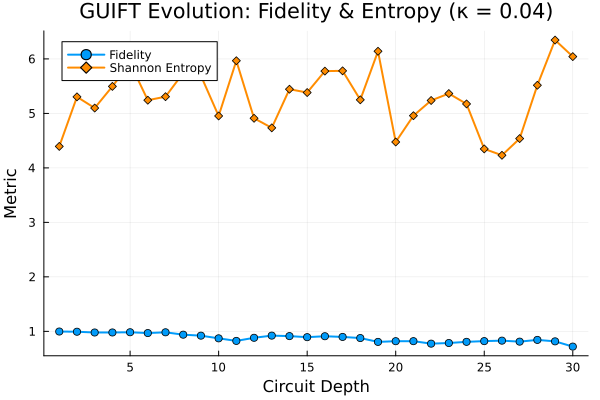

In [65]:
using LinearAlgebra, Random, Statistics, Printf, Plots

# === UTILITIES ===

"Generate the |0⟩^n state"
function init_state(n::Int)
    ψ = zeros(ComplexF64, 2^n)
    ψ[1] = 1.0 + 0im
    return ψ
end

"Apply single-qubit Ry rotation"
function apply_Ry!(ψ::Vector{ComplexF64}, θ::Float64, q::Int, n::Int)
    stride = 2^(n - q)
    for i in 1:stride:length(ψ)
        for j in 0:(stride ÷ 2 - 1)
            idx1 = i + j
            idx2 = idx1 + (stride ÷ 2)
            a, b = ψ[idx1], ψ[idx2]
            ψ[idx1] = cos(θ/2)*a - sin(θ/2)*b
            ψ[idx2] = sin(θ/2)*a + cos(θ/2)*b
        end
    end
end

"Apply single-qubit Rz rotation"
function apply_Rz!(ψ::Vector{ComplexF64}, ϕ::Float64, q::Int, n::Int)
    for i in 1:length(ψ)
        bit = (i - 1) >> (n - q) & 1
        ψ[i] *= exp(-im * ϕ * (bit == 1 ? 0.5 : -0.5))
    end
end

"Apply CNOT gate (control → target)"
function apply_CNOT!(ψ::Vector{ComplexF64}, ctrl::Int, tgt::Int, n::Int)
    for i in 1:length(ψ)
        ctrl_bit = (i - 1) >> (n - ctrl) & 1
        if ctrl_bit == 1
            flip_mask = 1 << (n - tgt)
            j = ((i - 1) ⊻ flip_mask) + 1
            if j > i
                ψ[i], ψ[j] = ψ[j], ψ[i]
            end
        end
    end
end

"Inject GUIFT curvature via global phase twist"
function apply_GUIFT_curvature!(ψ::Vector{ComplexF64}, κ::Float64, n::Int)
    for i in 1:length(ψ)
        ψ[i] *= exp(-im * κ * (i - 1) / n)
    end
end

"Compute fidelity between two pure states"
function fidelity(ψ1::Vector{ComplexF64}, ψ2::Vector{ComplexF64})
    dot = sum(conj(ψ1[i]) * ψ2[i] for i in eachindex(ψ1))
    return abs2(dot)
end

"Shannon entropy of probability amplitudes"
function shannon_entropy(ψ::Vector{ComplexF64})
    p = abs2.(ψ) ./ sum(abs2.(ψ))
    return -sum(p_i -> p_i > 0 ? p_i * log2(p_i) : 0.0, p)
end

# === MAIN SIMULATION ===

function run_guiFT_sim(n::Int, depth::Int, κ::Float64)
    ψ_ideal = init_state(n)
    ψ_curved = copy(ψ_ideal)
    fidelities = Float64[]
    entropies_curved = Float64[]

    for layer in 1:depth
        # Random layer of rotations
        for q in 1:n
            θ, ϕ = 2π * rand(), 2π * rand()
            apply_Ry!(ψ_ideal, θ, q, n)
            apply_Ry!(ψ_curved, θ, q, n)
            apply_Rz!(ψ_ideal, ϕ, q, n)
            apply_Rz!(ψ_curved, ϕ, q, n)
        end

        # Entangling layer
        for q in 1:2:(n-1)
            apply_CNOT!(ψ_ideal, q, q+1, n)
            apply_CNOT!(ψ_curved, q, q+1, n)
        end

        # Apply GUIFT curvature to curved state
        apply_GUIFT_curvature!(ψ_curved, κ, n)

        # Metrics
        push!(fidelities, fidelity(ψ_ideal, ψ_curved))
        push!(entropies_curved, shannon_entropy(ψ_curved))
    end

    return fidelities, entropies_curved
end

# === RUNNING & PLOTTING ===

n_qubits = 8
depth = 30
κ = 0.04

fvals, evals = run_guiFT_sim(n_qubits, depth, κ)

plot(1:depth, fvals, label="Fidelity", lw=2, marker=:circle)
plot!(1:depth, evals, label="Shannon Entropy", lw=2, marker=:diamond, color=:darkorange)
xlabel!("Circuit Depth")
ylabel!("Metric")
title!("GUIFT Evolution: Fidelity & Entropy (κ = $κ)")